Analysis of movement bout initiations and variations in neural representations.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats

from disp import set_font_size


DT = 0.1
T_WDW = [-2, 2]
DATA_DIR = 'data/ASENSORY_AZ'
GX = 'G2'
# GX = 'G4'

# Load data and extract neural/behavioral windows surrounding mvmt inits

In [2]:
# load data
t = np.arange(*T_WDW, DT)

t_minus = int(np.round(T_WDW[0]/DT))
t_plus = int(np.round(T_WDW[1]/DT))

## dict of to-be-arrays for all data vars (size = mvmt inits x timepoints)
data_dict = {
    'Motion': [], 'ForVel': [], 'AngVel': [], 'AbsAngVel': [],
    'G2': [], 'G3': [], 'G4': [], 'G5': []
}

## dicts of other predictors
factor_dicts = []

## loop through flies
for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    # loop through trials
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        data = pd.read_csv(os.path.join(trial_path, 'BigMAT.csv'))
        
        try:
            mvmts = pd.read_csv(os.path.join(trial_path, 'Start_Times_Exact.csv'))
        except Exception as e:
            print(e)
            continue
        
        # loop through mvmt inits
        for m_ctr, mvmt in mvmts.iterrows():
            # get t mask
            t_idx = int(np.round(mvmt['T1']/DT))
            t_start = t_idx + t_minus
            t_end = t_idx + t_plus
            
            # skip mvmt inits too close to trial beginning or end
            if (t_start < 0) or (t_end > len(data)):
                continue
            
            # get data
            data_dict['Motion'].append(np.array(data['Motion'][t_start:t_end]).flatten())
            data_dict['ForVel'].append(np.array(data['ForVel'][t_start:t_end]).flatten())
            data_dict['AngVel'].append(np.array(data['AngVel'][t_start:t_end]).flatten())
            data_dict['AbsAngVel'].append(np.abs(np.array(data['AngVel'][t_start:t_end])).flatten())
            
            data_dict['G2'].append(np.array(data['G2_avg'][t_start:t_end]).flatten())
            data_dict['G3'].append(np.array(data['G3_avg'][t_start:t_end]).flatten())
            data_dict['G4'].append(np.array(data['G4_avg'][t_start:t_end]).flatten())
            data_dict['G5'].append(np.array(data['G5_avg'][t_start:t_end]).flatten())
            
            # get factors
            factor_dict = {
                'Fly': fly,
                'T_Init': mvmt['T1'],
                'Mvmt_Ctr': m_ctr,
                'G2_Pre': np.nanmean(data_dict['G2'][-1][t < 0]),
                'G4_Pre': np.nanmean(data_dict['G4'][-1][t < 0]),
                'For_Vel_Pre': np.nanmean(data_dict['ForVel'][-1][t < 0]),
                'Motion_Post': np.nanmean(data_dict['Motion'][-1][0 <= t])
            }
            
            factor_dicts.append(factor_dict)

for k, v in data_dict.items():
    data_dict[k] = np.array(v)
    
factors = pd.DataFrame.from_dict(factor_dicts)

n_trials = len(factors)

File b'data/ASENSORY_AZ/20160614.Fly3/20160614.Fly3.4/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160614.Fly3/20160614.Fly3.2/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160614.Fly3/20160614.Fly3.1/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160601.Fly1/20160601.Fly1.2/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20180307.3/20180307.3.2/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20180220.3/20180220.3.3/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20180413.Fly9/20180413.Fly9.2/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160526.Fly1/20160526.Fly1.1/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160628.Fly4/20160628.Fly4.2/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160628.Fly4/20160628.Fly4.1/Start_Times_Exact.csv' does not exist
File b'data/ASENSORY_AZ/20160628.Fly4/20160628.Fly4.3/Start_Times_Exact.csv' does not exist


## Convert neural data to DF/F and detrend behav data

In [3]:
t_mask = (t < 0)

## neural data (convert to DF/F)
for k in ['G2', 'G3', 'G4', 'G5']:
    # subtract mean prior to mvmt init
    mean_pre = data_dict[k][:, t_mask].mean(1)
    mean_pre_tiled = np.tile(mean_pre[:, None], (1, len(t_mask)))
    data_dict[k] = (data_dict[k] - mean_pre_tiled) / mean_pre_tiled
    
## behavioral data (detrend)
for k in ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']:
    mean = np.nanmean(data_dict[k])
    std = np.nanstd(data_dict[k])
    data_dict[k] = (data_dict[k] - mean) / std

## Sort all data by G2 or G4 response (time-avg'd for 2 sec post mvmt init)

In [4]:
t_mask = (0 <= t)

## get G2 or G4 response
gx_rsp = np.nanmean(data_dict[GX][:, t_mask], 1)

## sort everything by G2 or G4 response
sorted_idx = np.argsort(gx_rsp)

gx_rsp_sorted = gx_rsp[sorted_idx]

data_dict_sorted = {}
for k, v in data_dict.items():
    data_dict_sorted[k] = v[sorted_idx]
    
factors_sorted = factors.reindex(sorted_idx)

## Plot heatmaps of neural and behav responses at mvmt init

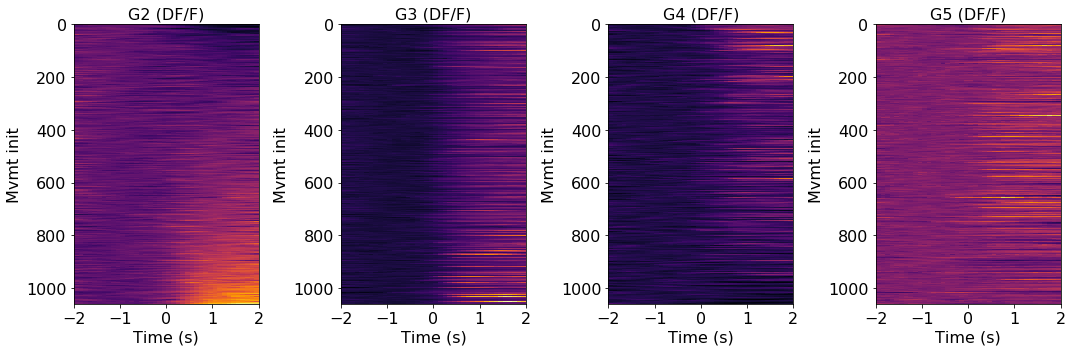

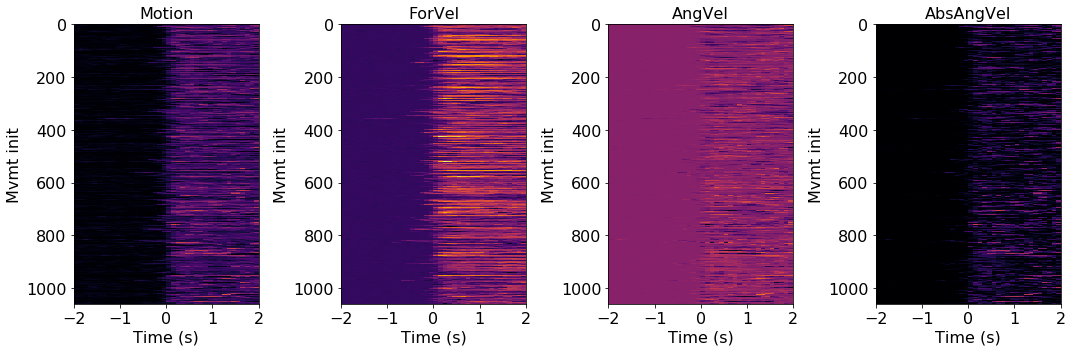

In [5]:
# plot neural responses
fig, axs = plt.subplots(1, 4, figsize=(15, 5), tight_layout=True)
for ax, k in zip(axs, ['G2', 'G3', 'G4', 'G5']):
    ax.imshow(
        data_dict_sorted[k], cmap='inferno', interpolation='none',
        aspect='auto', extent=[T_WDW[0], T_WDW[1], n_trials, 0])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mvmt init')
    ax.set_title('{} (DF/F)'.format(k))
    
for ax in axs:
    set_font_size(ax, 16)
    
# plot behavioral responses
fig, axs = plt.subplots(1, 4, figsize=(15, 5), tight_layout=True)
for ax, k in zip(axs, ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']):
    ax.imshow(
        data_dict_sorted[k], cmap='inferno', interpolation='none',
        aspect='auto', extent=[T_WDW[0], T_WDW[1], n_trials, 0])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mvmt init')
    ax.set_title(k)
    
for ax in axs:
    set_font_size(ax, 16)

## Plot correlations between G2 or G4 response and basic mvmt factors

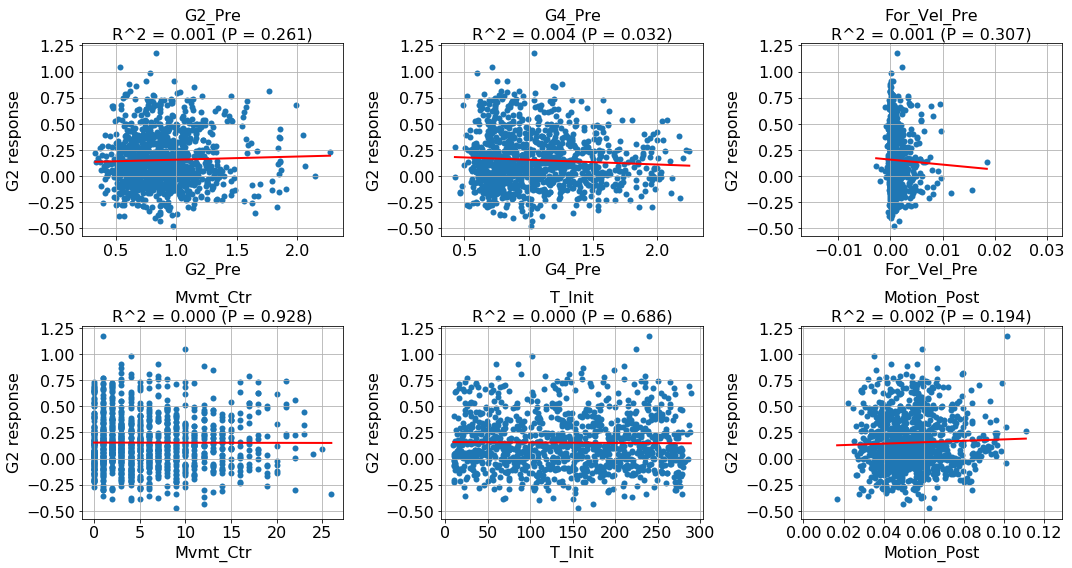

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)

for ax, k in zip(axs.flatten(), ['G2_Pre', 'G4_Pre', 'For_Vel_Pre', 'Mvmt_Ctr', 'T_Init', 'Motion_Post']):
    x_sorted = factors_sorted[k]
    
    r, p = stats.pearsonr(x_sorted, gx_rsp)
    
    ax.scatter(x_sorted, gx_rsp, lw=0)
    
    # plot line
    slp, icpt = stats.linregress(x_sorted, gx_rsp)[:2]
    x_line = np.array([x_sorted.min(), x_sorted.max()])
    y_line = slp*x_line + icpt
    
    ax.plot(x_line, y_line, c='r', lw=2)
    
    ax.set_xlabel(k)
    ax.set_ylabel('{} response'.format(GX))
    
    ax.set_title('{0}\nR^2 = {1:.3f} (P = {2:.3f})'.format(k, r**2, p))
    
for ax in axs.flatten():
    ax.grid()
    set_font_size(ax, 16)

# Run PCA on behav data to identify principal axes of variation

In [7]:
# run PCA on behavioral data
data_behav_sorted = np.concatenate([
    data_dict_sorted['Motion'],
    data_dict_sorted['ForVel'],
    data_dict_sorted['AngVel'],
    data_dict_sorted['AbsAngVel'],
], axis=1)

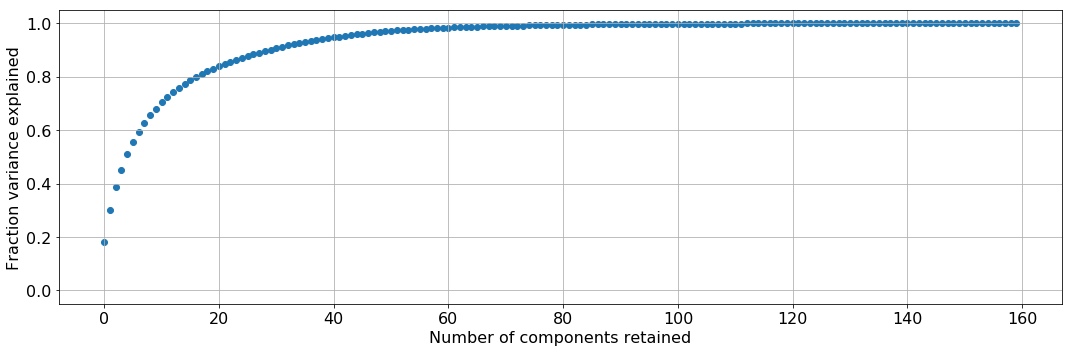

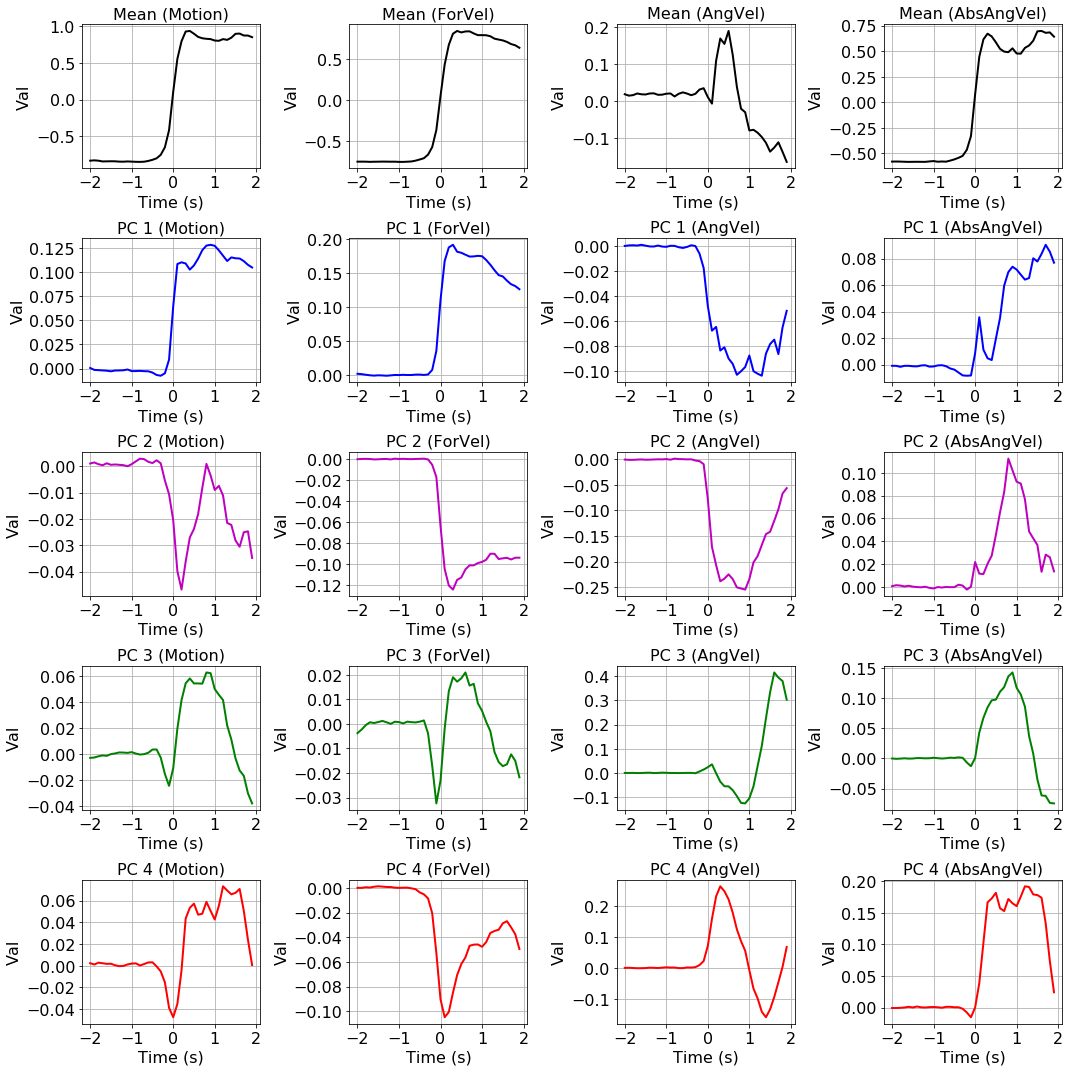

In [8]:
from sklearn import decomposition

pca = decomposition.PCA()
data_behav_sorted_pca = pca.fit_transform(data_behav_sorted)

# get mean
mean = {
    'Motion': pca.mean_[:len(t)],
    'ForVel': pca.mean_[len(t):2*len(t)],
    'AngVel': pca.mean_[2*len(t):3*len(t)],
    'AbsAngVel': pca.mean_[3*len(t):4*len(t)],
}

# get components
components = []
for component_ in pca.components_:
    component = {
        'Motion': component_[:len(t)],
        'ForVel': component_[len(t):2*len(t)],
        'AngVel': component_[2*len(t):3*len(t)],
        'AbsAngVel': component_[3*len(t):4*len(t)],
    }
    components.append(component)

# plot explained variance vs num components kept
fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)
ax.scatter(np.arange(data_behav_sorted.shape[1]), np.cumsum(pca.explained_variance_ratio_))

ax.set_ylim(-0.05, 1.05)

ax.set_xlabel('Number of components retained')
ax.set_ylabel('Fraction variance explained')

ax.grid()

set_font_size(ax, 16)

# plot means
fig, axs = plt.subplots(5, 4, figsize=(15, 15), tight_layout=True)

for ax, k in zip(axs[0], ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']):
    ax.plot(t, mean[k], lw=2, color='k')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Val')
    ax.set_title('Mean ({})'.format(k))
    
    set_font_size(ax, 16)
    ax.grid()

# plot components
for ctr, (component, ax_row, c) in enumerate(zip(components, axs[1:], ['b', 'm', 'g', 'r'])):
    for ax, k in zip(ax_row, ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']):
        
        ax.plot(t, component[k], lw=2, color=c)
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Val')
        ax.set_title('PC {} ({})'.format(ctr + 1, k))
        
        set_font_size(ax, 16)
        ax.grid()

## Plot correlations btwn G2 or G4 response and projection onto indiv PCs

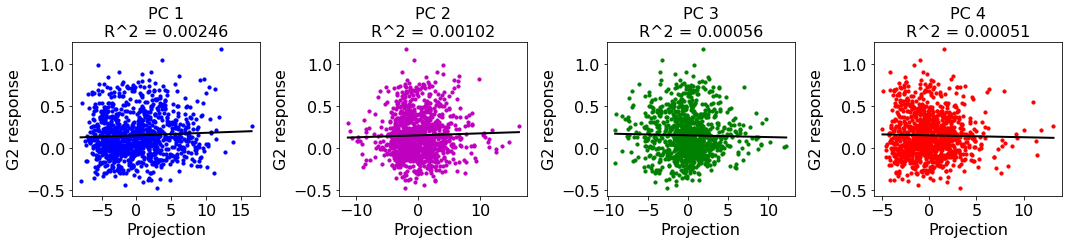

In [9]:
# plot projections onto diff PCs vs g2 or g4 response
fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), tight_layout=True)
colors = ['b', 'm', 'g', 'r']

for ctr, (ax, color) in enumerate(zip(axs, colors)):
    # get projection onto PC (ctr + 1)
    x = data_behav_sorted_pca[:, ctr]
    
    # plot scatter
    ax.scatter(x, gx_rsp, s=10, c=color)
    
    # plot line
    slp, icpt, r, _, p = stats.linregress(x, gx_rsp)
    x_line = np.array([x.min(), x.max()])
    y_line = slp*x_line + icpt
    
    ax.plot(x_line, y_line, c='k', lw=2)
    
    ax.set_xlabel('Projection')
    ax.set_ylabel('{} response'.format(GX))
    ax.set_title('PC {0}\nR^2 = {1:.5f}'.format(ctr+1, r**2))
    
    set_font_size(ax, 16)

## Plot heatmaps of G2 or G4 response over projection onto pairs of top PCs

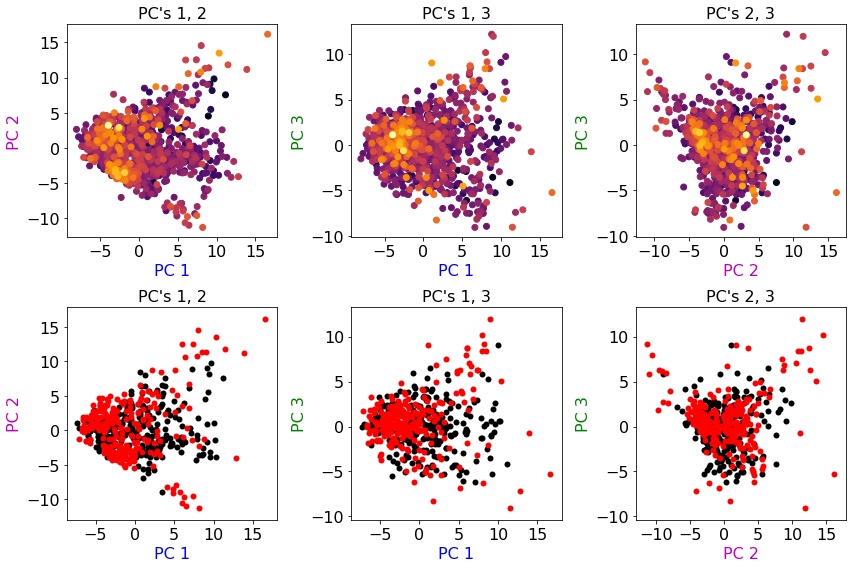

In [10]:
gx_slice_lower = np.arange(len(gx_rsp_sorted)) <= (len(gx_rsp_sorted) / 4)
gx_slice_upper = np.flip(gx_slice_lower, 0)

# plot PCA values colored by g2 or g4 rsp
fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

for ax_col, pcs in zip(axs.T, [(0, 1), (0, 2), (1, 2)]):
    
    pc_x = data_behav_sorted_pca[:, pcs[0]]
    pc_y = data_behav_sorted_pca[:, pcs[1]]
    
    ax_col[0].scatter(
        pc_x, pc_y, c=gx_rsp_sorted,
        cmap='inferno', vmin=gx_rsp_sorted.min(), vmax=gx_rsp_sorted.max())
    
    # plot bottom and top 25% of data
    ax_col[1].scatter(
        pc_x[gx_slice_lower], pc_y[gx_slice_lower], c='k', lw=0)
    ax_col[1].scatter(
        pc_x[gx_slice_upper], pc_y[gx_slice_upper], c='r', lw=0)
    
    for ax in ax_col:
        ax.set_xlabel('PC {}'.format(pcs[0] + 1), color=colors[pcs[0]])
        ax.set_ylabel('PC {}'.format(pcs[1] + 1), color=colors[pcs[1]])
        ax.set_title('PC\'s {}, {}'.format(pcs[0] + 1, pcs[1] + 1))
    
for ax in axs.flatten():
    set_font_size(ax, 16)

Hotter colors are higher g2 or g4 responses.

# Fit standard multivariate linear model predicting G2 or G4 response from behav

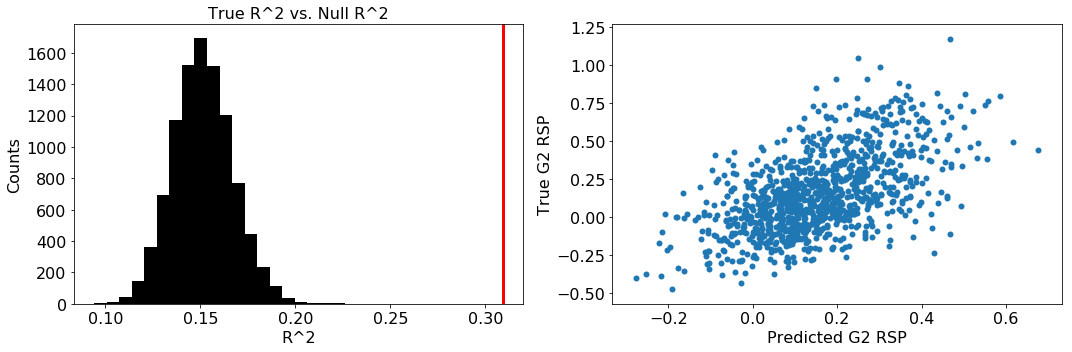

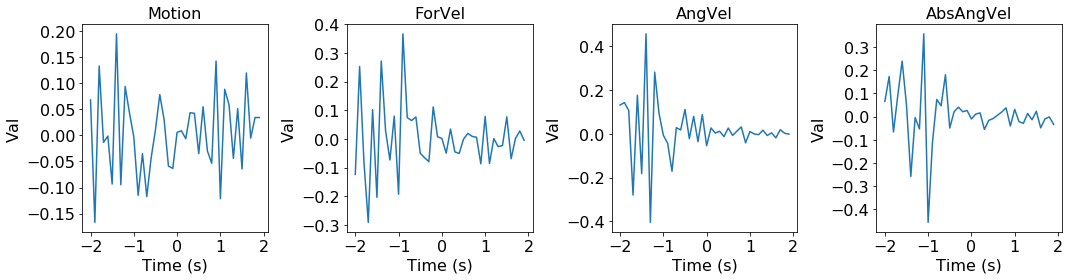

In [11]:
# find best linear combo of behavior predicting G2 or G4 response
from sklearn import linear_model

rgr = linear_model.LinearRegression().fit(data_behav_sorted, gx_rsp_sorted)
score = rgr.score(data_behav_sorted, gx_rsp_sorted)

# make null predictions
scores_null = []

for ctr in range(10000):
    gx_rsp_shuffled = gx_rsp_sorted[np.random.permutation(len(gx_rsp_sorted))]
    rgr_null = linear_model.LinearRegression().fit(data_behav_sorted, gx_rsp_shuffled)
    scores_null.append(rgr_null.score(data_behav_sorted, gx_rsp_shuffled))

# plot some basics
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

## distribution of shuffled scores and true score
axs[0].hist(scores_null, bins=20, color='k', lw=0)
axs[0].axvline(score, c='r', lw=3)

axs[0].set_xlabel('R^2')
axs[0].set_ylabel('Counts')
axs[0].set_title('True R^2 vs. Null R^2')

## predicted vs true
axs[1].scatter(rgr.predict(data_behav_sorted), gx_rsp_sorted, lw=0)
axs[1].set_xlabel('Predicted {} RSP'.format(GX))
axs[1].set_ylabel('True {} RSP'.format(GX))

for ax in axs:
    set_font_size(ax, 16)

fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

axs[0].plot(t, rgr.coef_[:len(t)])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Val')
axs[0].set_title('Motion')

axs[1].plot(t, rgr.coef_[len(t):2*len(t)])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Val')
axs[1].set_title('ForVel')

axs[2].plot(t, rgr.coef_[2*len(t):3*len(t)])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Val')
axs[2].set_title('AngVel')

axs[3].plot(t, rgr.coef_[3*len(t):4*len(t)])
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Val')
axs[3].set_title('AbsAngVel')

for ax in axs:
    set_font_size(ax, 16)

## Fit linear model using top PCA components as low-dim basis

In [12]:
N_COMP = 45
dim = data_behav_sorted.shape[1]

rgr = linear_model.LinearRegression().fit(data_behav_sorted_pca[:, :N_COMP], gx_rsp_sorted)
score = rgr.score(data_behav_sorted_pca[:, :N_COMP], gx_rsp_sorted)

# make null predictions
scores_null = []

for ctr in range(10000):
    gx_rsp_shuffled = gx_rsp_sorted[np.random.permutation(len(gx_rsp_sorted))]
    rgr_null = linear_model.LinearRegression().fit(data_behav_sorted_pca[:, :N_COMP], gx_rsp_shuffled)
    scores_null.append(rgr_null.score(data_behav_sorted_pca[:, :N_COMP], gx_rsp_shuffled))

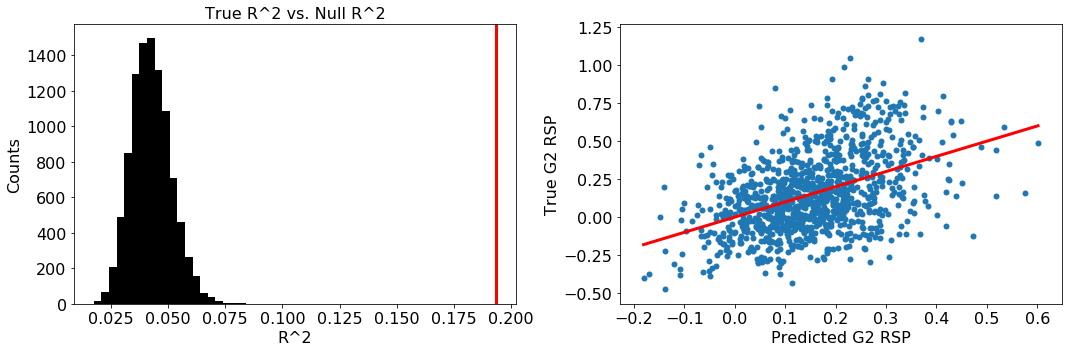

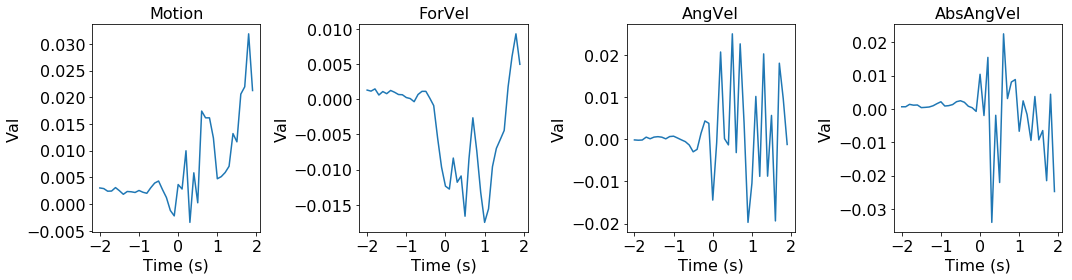

In [13]:
# plot some basics
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

## distribution of shuffled scores and true score
axs[0].hist(scores_null, bins=20, color='k', lw=0)
axs[0].axvline(score, c='r', lw=3)

axs[0].set_xlabel('R^2')
axs[0].set_ylabel('Counts')
axs[0].set_title('True R^2 vs. Null R^2')

## predicted vs true
y_hat = rgr.predict(data_behav_sorted_pca[:, :N_COMP])
axs[1].scatter(y_hat, gx_rsp_sorted, lw=0)

# plot line
slp, icpt, r, _, p = stats.linregress(y_hat, gx_rsp_sorted)
x_line = np.array([y_hat.min(), y_hat.max()])
y_line = slp*x_line + icpt

axs[1].plot(x_line, y_line, c='r', lw=3)

axs[1].set_xlabel('Predicted {} RSP'.format(GX))
axs[1].set_ylabel('True {} RSP'.format(GX))

for ax in axs:
    set_font_size(ax, 16)

# plot reconstructed coefficients
fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

coef_ = pca.inverse_transform([np.concatenate([rgr.coef_, np.zeros(dim - N_COMP)])])[0] - pca.mean_

axs[0].plot(t, coef_[:len(t)])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Val')
axs[0].set_title('Motion')

axs[1].plot(t, coef_[len(t):2*len(t)])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Val')
axs[1].set_title('ForVel')

axs[2].plot(t, coef_[2*len(t):3*len(t)])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Val')
axs[2].set_title('AngVel')

axs[3].plot(t, coef_[3*len(t):4*len(t)])
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Val')
axs[3].set_title('AbsAngVel')

for ax in axs:
    set_font_size(ax, 16)

## Repeat linear model fit with PC components using train/test data to get var expl estimate

In [14]:
N_COMP = 45
P_TRAIN = 0.8
N_SPLITS = 1000

np.random.seed(0)
dim = data_behav_sorted.shape[1]

scores_train = []
scores_test = []
coefs = []

x_xmpl = None
y_xmpl = None

for split in range(N_SPLITS):
    # select rows
    n_train = int(P_TRAIN * n_trials)
    
    mask_train = np.zeros(n_trials, dtype=bool)
    mask_train[np.random.permutation(n_trials)[:n_train]] = True
    mask_test = ~mask_train
    
    assert mask_train.sum() == n_train
    
    rgr = linear_model.LinearRegression().fit(data_behav_sorted_pca[:, :N_COMP][mask_train], gx_rsp_sorted[mask_train])
    score_train = rgr.score(data_behav_sorted_pca[:, :N_COMP][mask_train], gx_rsp_sorted[mask_train])
    
    score_test = rgr.score(data_behav_sorted_pca[:, :N_COMP][mask_test], gx_rsp_sorted[mask_test])
    
    scores_train.append(score_train)
    scores_test.append(score_test)
    
    coef = pca.inverse_transform([np.concatenate([rgr.coef_, np.zeros(dim - N_COMP)])])[0] - pca.mean_
    coefs.append(coef)
    
    if split == 0:
        y_hat_xmpl = rgr.predict(data_behav_sorted_pca[:, :N_COMP][mask_test])
        y_xmpl = gx_rsp_sorted[mask_test]
    
coefs = np.array(coefs)

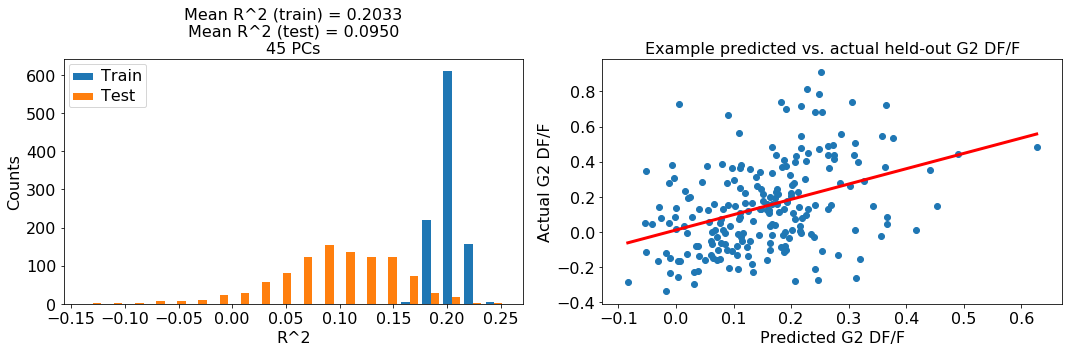

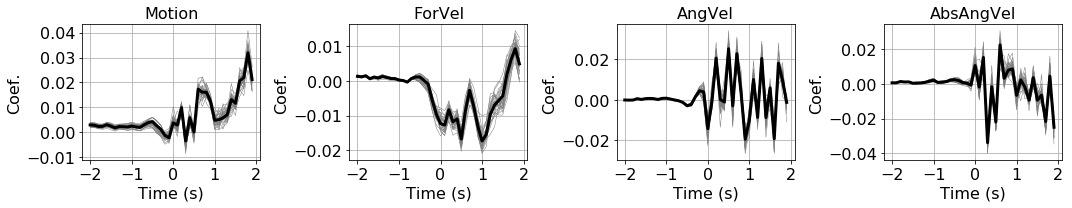

In [15]:
N_EXAMPLES = 30

# plot distribution of R^2 over splits
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

axs[0].hist(np.array([scores_train, scores_test]).T, bins=20)

axs[0].set_xlabel('R^2')
axs[0].set_ylabel('Counts')
axs[0].legend(['Train', 'Test'])

axs[0].set_title('Mean R^2 (train) = {0:.4f}\nMean R^2 (test) = {1:.4f}\n{2} PCs'.format(
    np.mean(scores_train), np.mean(scores_test), N_COMP))

axs[1].scatter(y_hat_xmpl, y_xmpl)

slp, icpt, r, _, p = stats.linregress(y_hat_xmpl, y_xmpl)
x_line = np.array([y_hat_xmpl.min(), y_hat_xmpl.max()])
y_line = slp*x_line + icpt

axs[1].plot(x_line, y_line, c='r', lw=3)

axs[1].set_xlabel('Predicted {} DF/F'.format(GX))
axs[1].set_ylabel('Actual {} DF/F'.format(GX))

axs[1].set_title('Example predicted vs. actual held-out {} DF/F'.format(GX))

for ax in axs:
    set_font_size(ax, 16)

# plot distribution of coefficients
fig, axs = plt.subplots(1, 4, figsize=(15, 3), tight_layout=True)

starts = [    0,   len(t), 2*len(t), 3*len(t)]
stops = [len(t), 2*len(t), 3*len(t), 4*len(t)]
keys = ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']

for start, stop, k, ax in zip(starts, stops, keys, axs):
    v = coefs[:, start:stop]
    
    # plot indiv traces
    ax.plot(t, v[:N_EXAMPLES].T, lw=0.5, c='gray')
    
    # plot mean
    ax.plot(t, v.mean(0), lw=3, c='k')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Coef.')
    ax.set_title(k)
    
    ax.grid()
    
    set_font_size(ax, 16)